In [1]:
import os

import matplotlib.pyplot as plt
import xarray as xr

plt.style.use("ggplot")

# Compare raw hour and monthly ERA5-Land datasets

ERA5-Land represents "accumulated" variables in a strange way (see [here](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-Temporalfrequency) for details). 

As a sense check, and to prove I have more-or-less understood the documentation, this notebook attempts to recreate the monthly dataset from the raw hourly dataset, and then compares the result to the "official" monthly dataset downloaded from the CDS.

As a starting point, I have downloaded "raw" hourly and monthly data from the CDS for 2020 and 2021. The files are available on the JupyterHub here:

    shared/JES/era5land_test

In [2]:
# List of all "accumulated" par and their "short names"
accum_pars_dict = {
    "surface_runoff": "sro",
    "sub_surface_runoff": "ssro",
    "snowmelt": "smlt",
    "snowfall": "sf",
    "surface_sensible_heat_flux": "sshf",
    "surface_latent_heat_flux": "slhf",
    "surface_solar_radiation_downwards": "ssrd",
    "surface_thermal_radiation_downwards": "strd",
    "surface_net_solar_radiation": "ssr",
    "surface_net_thermal_radiation": "str",
    "total_evaporation": "e",
    "runoff": "ro",
    "total_precipitation": "tp",
    "evaporation_from_the_top_of_canopy": "evatc",
    "evaporation_from_bare_soil": "evabs",
    "evaporation_from_open_water_surfaces_excluding_oceans": "evaow",
    "evaporation_from_vegetation_transpiration": "evavt",
    "potential_evaporation": "pev",
}

The code below reads the raw hourly data and converts it to monthly. This is the same loigc as implemented in `nivapy.da.get_era5land_cds_api_gridded()`.

In [3]:
# Convert hourly to monthly
hourly_fold = "/home/jovyan/shared/JES/era5land_test/era5land_raw_hourly"
raw_freq = "H"
out_freq = "M"

nc_paths = os.path.join(hourly_fold, "*.nc")
with xr.open_mfdataset(nc_paths, combine="by_coords") as ds:
    # Resample to desired frequency
    if raw_freq == "M":
        if out_freq == "A":
            # Downsampling
            ds = ds.resample({"time": out_freq}, skipna=True).mean()
        elif out_freq == "M":
            pass
        else:
            # Upsampling to hourly or daily
            ds = ds.resample({"time": out_freq}).interpolate("linear")
    else:
        # Raw is hourly
        if out_freq == "H":
            pass
        else:
            # Downsampling
            # 'Accumulated' parameters are represpended strangely in ERA5-Land. See
            # https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-Temporalfrequency
            # For these parameters, daily totals for day X are the values for hour 00:00
            # on day (X+1)
            for par in accum_pars_dict.values():
                if par in ds.keys():
                    # Get just the results for 00:00, setting all others to NaN
                    ds[par] = ds[par].where(ds["time"].dt.hour == 0).shift(time=-1)
            ds = ds.resample({"time": out_freq}, skipna=True).mean()

    ds.load()

In [4]:
# Read the "official" monthly dataset from the CDS
monthly_fold = "/home/jovyan/shared/JES/era5land_test/era5land_raw_monthly"
nc_paths = os.path.join(monthly_fold, "*.nc")
with xr.open_mfdataset(nc_paths, combine="by_coords") as ds2:
    ds2.load()

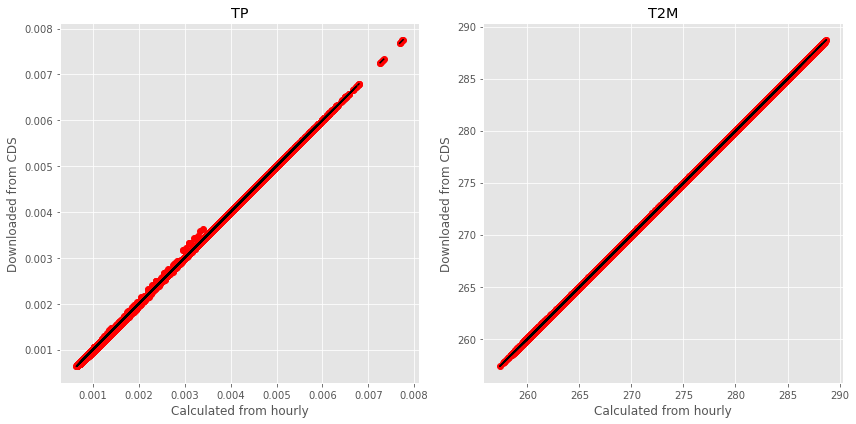

In [5]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(ds["tp"].data.flatten(), ds2["tp"].data.flatten(), "ro")
axes[0].plot(ds["tp"].data.flatten(), ds["tp"].data.flatten(), "k-")
axes[0].set_title("TP")

axes[1].plot(ds["t2m"].data.flatten(), ds2["t2m"].data.flatten(), "ro")
axes[1].plot(ds["t2m"].data.flatten(), ds["t2m"].data.flatten(), "k-")
axes[1].set_title("T2M")

for ax in axes:
    ax.set_xlabel("Calculated from hourly")
    ax.set_ylabel("Downloaded from CDS")

plt.tight_layout()